# Modelação com XGBoost - Abordagem Class Weight

## Objetivo
Este notebook foca-se em resolver o problema do **Desequilíbrio de Classes** (Class Imbalance) utilizando **Pesos de Classe**.
Nos modelos anteriores, o XGBoost atingia 57% de accuracy mas ignorava quase completamente os **Empates** (Recall ~0%).

Nesta versão, utilizaremos:
1.  **Novas Features Avançadas:** xG, Posse de Bola, Passes Progressivos e Forma de Empates.
2.  **Class Weights (Pesos de Classe):** Forçar o modelo a valorizar os Empates, penalizando mais os erros nessa classe utilize `sample_weight`.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight

In [2]:
# 1. Carregar Dados
df = pd.read_csv(r"d:\Diogo\Ambiente de Trabalho\PROJETO\Datasets\dataset_final_merged_v2.csv", low_memory=False)

# 2. Definição de Features (Set Avançado)
features = [
    # Histórico Geral
    'Home_hist_Pontos', 'Home_hist_GolosMarcados', 'Home_hist_GolosSofridos',
    'Home_hist_DiferençaDeGolos', 'Home_hist_Vitórias', 'Home_hist_Derrotas', 'Home_hist_Empates',
    'Away_hist_Pontos', 'Away_hist_GolosMarcados', 'Away_hist_GolosSofridos',
    'Away_hist_DiferençaDeGolos', 'Away_hist_Vitórias', 'Away_hist_Derrotas', 'Away_hist_Empates',
    
    # Forma Recente (5 Jogos)
    'Casa_Form_Pts5', 'Casa_Form_GM5', 'Casa_Form_GS5',
    'Visitante_Form_Pts5', 'Visitante_Form_GM5', 'Visitante_Form_GS5',
    'Casa_Form_Empates5', 'Visitante_Form_Empates5',
    
    # Métricas Avançadas (xG, Posse, etc.)
    'Home_hist_GolosEsperados', 'Home_hist_GolosEsperadosSofridos',
    'Away_hist_GolosEsperados', 'Away_hist_GolosEsperadosSofridos',
    'Home_hist_PosseDeBola', 'Away_hist_PosseDeBola',
    'Home_hist_PassesProgressivos', 'Away_hist_PassesProgressivos',
    'Home_hist_JogosSemSofrerGolos', 'Away_hist_JogosSemSofrerGolos'
]

# Limpeza de NaNs nas features
df = df.dropna(subset=features)

X = df[features]
y = df['Resultado_Final']

# Encoding do Target
le = LabelEncoder()
y = le.fit_transform(y)
print(f"Classes Mapeadas: {list(zip(le.classes_, le.transform(le.classes_)))} ")
# Ex: [('A', 0), ('D', 1), ('H', 2)]

Classes Mapeadas: [('A', np.int64(0)), ('D', np.int64(1)), ('H', np.int64(2))] 


In [3]:
# 3. Split Treino/Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Calcular Pesos das Classes (A Chave para o Balanced)
print("A calcular pesos para equilibrar as classes...")
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

# Nota: Classes menos frequentes (Empates) terão pesos maiores.

A calcular pesos para equilibrar as classes...


In [4]:
# 5. Treinar Modelo XGBoost (com sample_weight)
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    n_estimators=100,
    learning_rate=0.05,  # Taxa menor para maior cautela
    max_depth=4,         # Profundidade menor para evitar overfitting
    random_state=42,
    eval_metric='mlogloss'
)

print("A treinar modelo...")
model.fit(X_train, y_train, sample_weight=sample_weights)
print("Concluído.")

A treinar modelo...
Concluído.


Accuracy Teste: 0.493

Classification Report:
              precision    recall  f1-score   support

           A       0.54      0.49      0.51       270
           D       0.32      0.47      0.38       232
           H       0.66      0.51      0.58       383

    accuracy                           0.49       885
   macro avg       0.51      0.49      0.49       885
weighted avg       0.53      0.49      0.50       885



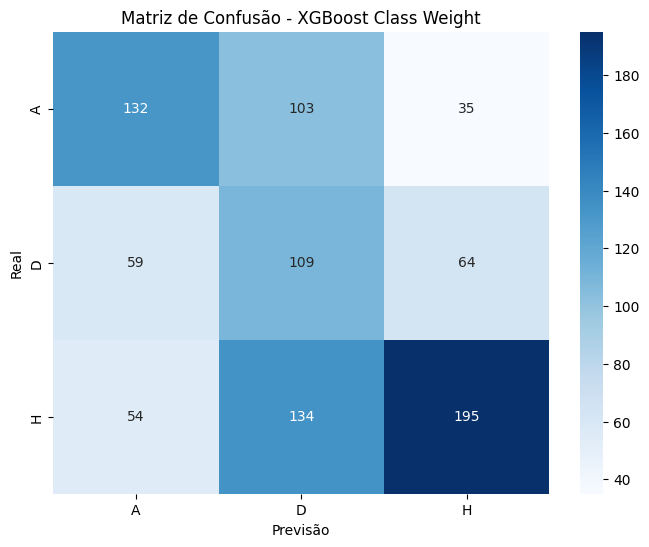

In [5]:
# 6. Avaliação
y_pred = model.predict(X_test)
target_names = [str(c) for c in le.classes_]

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy Teste: {acc:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Matriz de Confusão - XGBoost Class Weight')
plt.ylabel('Real')
plt.xlabel('Previsão')
plt.show()

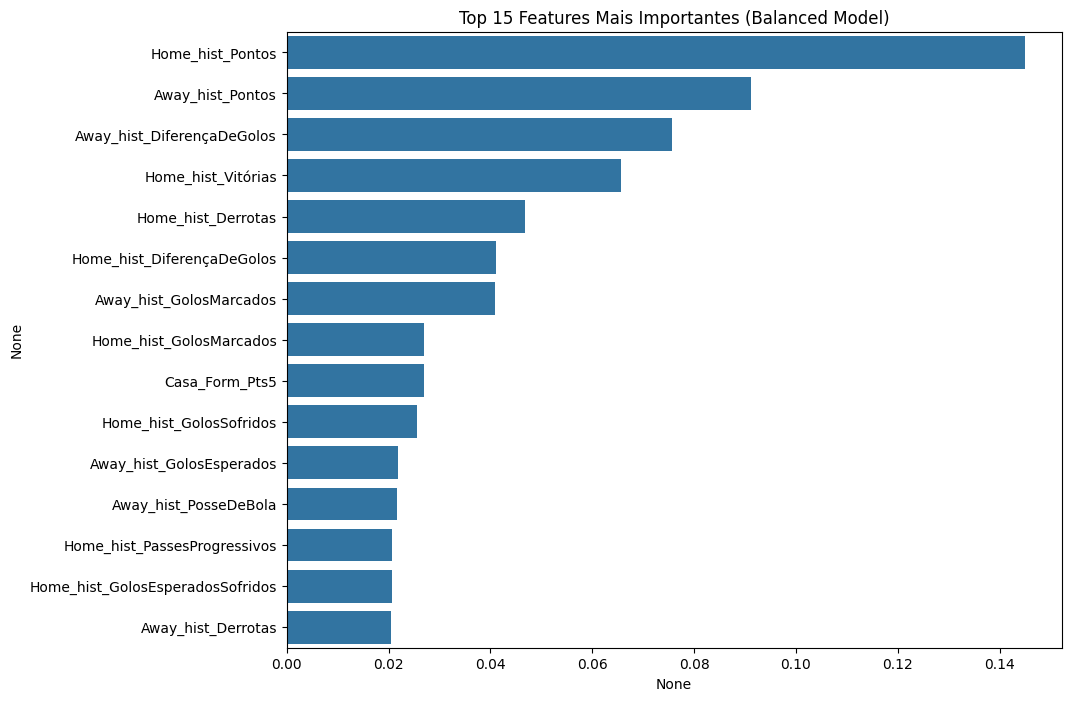

In [6]:
# 7. Feature Importance
importances = model.feature_importances_
feature_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_imp.head(15), y=feature_imp.head(15).index)
plt.title("Top 15 Features Mais Importantes (Balanced Model)")
plt.show()